<a href="https://colab.research.google.com/github/lazy-wolf/Sample/blob/main/assignmentTensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import PIL.Image as Image
import tensorflow_datasets as tfds

In [ ]:
image_shape = (128,128)

In [ ]:
m = tf.keras.Sequential([
    hub.KerasLayer("https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2")
])
m.build([None, 128, 128, 3])

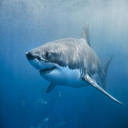

In [ ]:
shark_fish = Image.open('./image.jpg').resize(image_shape)
shark_fish

In [ ]:
# Normalizing
shark_fish = np.array(shark_fish)/255.0
shark_fish.shape

(128, 128, 3)

In [ ]:
shark = shark_fish[np.newaxis,...]

In [ ]:
shark.shape

(1, 128, 128, 3)

In [ ]:
prediction = m.predict(shark)
prediction.shape

1/1 [==============================] - 0s 86ms/step


(1, 1001)

In [ ]:
prediction_label_index = np.argmax(prediction)
prediction_label_index

3

In [ ]:
image_labels = []
with open ("./ImageNetlabels.txt", "r") as file:
  image_labels = file.read().splitlines()
image_labels[:6]

['background',
 'tench',
 'goldfish',
 'great white shark',
 'tiger shark',
 'hammerhead']

In [ ]:
image_labels[prediction_label_index]

'great white shark'

In [ ]:
# tfds.list_builders()

In [2]:
ds, info = tfds.load('imagewang/160px', shuffle_files=True, with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

KeyboardInterrupt: ignored

In [3]:
(training_set, validation_set), dataset_info = tfds.load(
    'imagewang/160px',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/2 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/14669 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagewang/160px/2.0.0.incompleteHVGDI7/imagewang-train.tfrecord*...:   0%|…

Generating validation examples...:   0%|          | 0/3929 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imagewang/160px/2.0.0.incompleteHVGDI7/imagewang-validation.tfrecord*...: …

Dataset imagewang downloaded and prepared to /root/tensorflow_datasets/imagewang/160px/2.0.0. Subsequent calls will reuse this data.


In [4]:
training_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [5]:
validation_set

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [6]:
num_classes = dataset_info.features['label'].num_classes
num_classes

20

In [7]:
num_training_examples = 0
num_validation_examples = 0
for example in training_set:
    num_training_examples += 1
for example in validation_set:
    num_validation_examples += 1
print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

Total Number of Classes: 20
Total Number of Training Images: 10268
Total Number of Validation Images: 4401 



In [8]:
for i, example in enumerate(training_set.take(5)):
    print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (160, 198, 3) label: 19
Image 2 shape: (160, 213, 3) label: 1
Image 3 shape: (160, 238, 3) label: 10
Image 4 shape: (160, 186, 3) label: 13
Image 5 shape: (160, 222, 3) label: 12


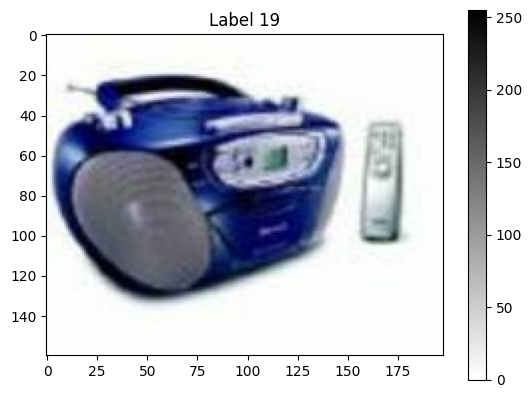

In [9]:
for image, label in training_set.take(1):
    break
image = image.numpy()
plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.title('Label {}'.format(label))
plt.colorbar()
plt.grid(False)
plt.show()

In [10]:
IMAGE_RES = 128
def format_image(image, label):
    image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
    return image, label
BATCH_SIZE = 32
train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)
validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)
print(train_batches)
print(validation_batches)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>


In [11]:
URL = "https://www.kaggle.com/models/google/mobilenet-v2/frameworks/TensorFlow2/variations/035-128-classification/versions/2"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))

In [12]:
model = tf.keras.Sequential([
  feature_extractor,
  tf.keras.layers.Dense(num_classes)
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1001)              1692489   
                                                                 
 dense (Dense)               (None, 20)                20040     
                                                                 
Total params: 1712529 (6.53 MB)
Trainable params: 20040 (78.28 KB)
Non-trainable params: 1692489 (6.46 MB)
_________________________________________________________________


In [13]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [14]:
EPOCHS = 25
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

Epoch 1/25
321/321 [==============================] - 85s 253ms/step - loss: 0.6498 - accuracy: 0.8201 - val_loss: 0.4014 - val_accuracy: 0.8850
Epoch 2/25
321/321 [==============================] - 60s 186ms/step - loss: 0.3048 - accuracy: 0.9045 - val_loss: 0.3869 - val_accuracy: 0.8916
Epoch 3/25
321/321 [==============================] - 60s 186ms/step - loss: 0.2353 - accuracy: 0.9277 - val_loss: 0.3923 - val_accuracy: 0.8871
Epoch 4/25
321/321 [==============================] - 60s 186ms/step - loss: 0.1850 - accuracy: 0.9430 - val_loss: 0.3899 - val_accuracy: 0.8941
Epoch 5/25
321/321 [==============================] - 59s 185ms/step - loss: 0.1573 - accuracy: 0.9486 - val_loss: 0.4145 - val_accuracy: 0.8893
Epoch 6/25
321/321 [==============================] - 59s 185ms/step - loss: 0.1283 - accuracy: 0.9602 - val_loss: 0.4271 - val_accuracy: 0.8900
Epoch 7/25
321/321 [==============================] - 60s 186ms/step - loss: 0.1122 - accuracy: 0.9654 - val_loss: 0.4218 - val_ac

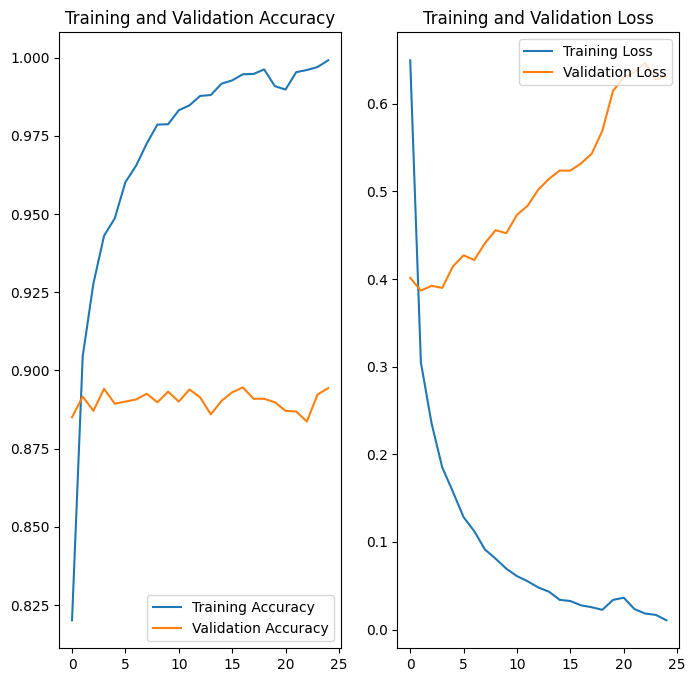

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(EPOCHS)
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [21]:
class_names = np.array(dataset_info.features['label'].names)
print(class_names)

['n03394916' 'n03417042' 'n02089973' 'n02086240' 'n02105641' 'n02087394'
 'n02099601' 'n02115641' 'n03445777' 'n02102040' 'n03425413' 'n03888257'
 'n03028079' 'n03000684' 'n01440764' 'n02093754' 'n02111889' 'n02096294'
 'n02088364' 'n02979186']


In [22]:
image_batch, label_batch = next(iter(train_batches))
image_batch = image_batch.numpy()
label_batch = label_batch.numpy()
predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()
predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]
print(predicted_class_names)

1/1 [==============================] - 0s 138ms/step
['n02102040' 'n02979186' 'n03417042' 'n03888257' 'n02102040' 'n03888257'
 'n03000684' 'n03417042' 'n02979186' 'n03394916' 'n03888257' 'n03417042'
 'n02102040' 'n03888257' 'n03445777' 'n03417042' 'n01440764' 'n03394916'
 'n03028079' 'n03445777' 'n02102040' 'n03028079' 'n03028079' 'n03445777'
 'n01440764' 'n03445777' 'n02979186' 'n02979186' 'n03445777' 'n03445777'
 'n01440764' 'n03028079']


In [18]:
print("Labels:           ", label_batch)
print("Predicted labels: ", predicted_ids)

Labels:            [12  9 13  0 11 19 19  1  8 13 19  0 11 11 11  0 11  0 11  1  0  5  8  9
  4 12  0 19 14  8  9 10]
Predicted labels:  [12  9 13  0 11 19 19  1  8 13 19  0 11 11 11  0 11  0 11  1  0  5  8  9
  4 12  0 19 14  8  9 10]


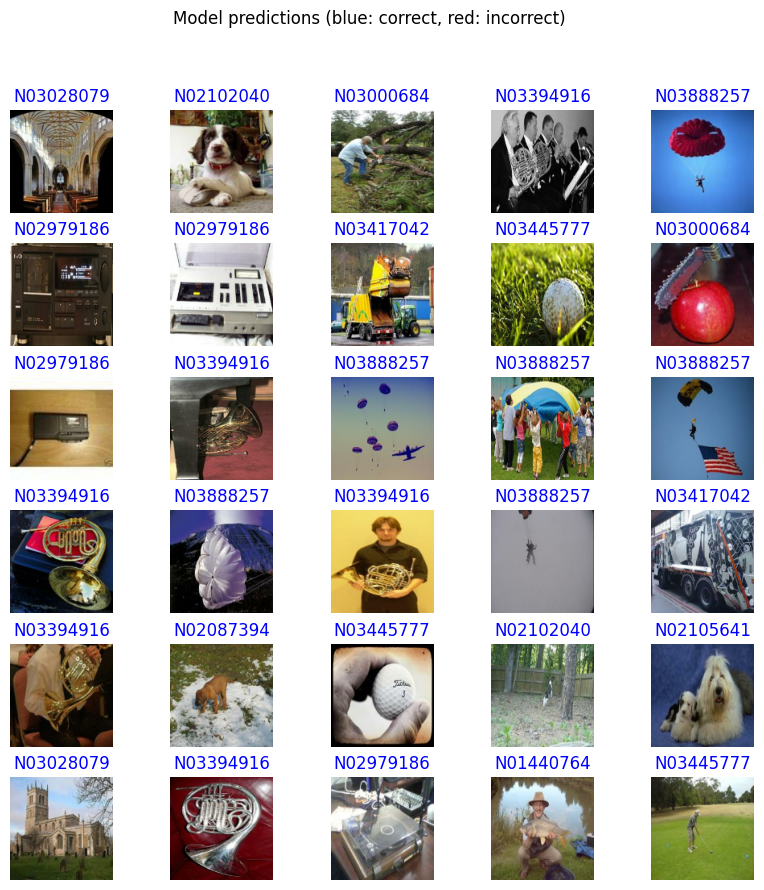

In [19]:
plt.figure(figsize=(10,10))
for n in range(30):
    plt.subplot(6,5,n+1)
    plt.subplots_adjust(hspace = 0.3)
    plt.imshow(image_batch[n])
    color = "blue" if predicted_ids[n] == label_batch[n] else "red"
    plt.title(predicted_class_names[n].title(), color=color)
    plt.axis('off')
_ = plt.suptitle("Model predictions (blue: correct, red: incorrect)")